# LA Bikeshare Data
After working on my [Google Location History Notebook](https://nbviewer.jupyter.org/github/black-tea/google_location_history/blob/master/MyTimeinLA.ipynb), I wanted to dig into spatial data a bit more. I've seen a number of different bikeshare data analyses in the past few years; I thought I would give it a try myself.
### Extract: Get the data from LA Metro
Go to https://bikeshare.metro.net/about/data/ and download all the (1) trip data and (2) station information. As of 7/15/2017, there is one year of trip data released, separated by quarters. Everything is in CSV format.

In [105]:
##### Setup
%matplotlib inline
import urllib2
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pysal as ps
import matplotlib.pyplot as plt
import datetime
import folium

##### About LA Metro Bikeshare Data
Attribute information is provided directly on the [LA Metro website](https://bikeshare.metro.net/about/data/). The station information contains the following fields:
* Station ID: Unique identifier for the station
* Station Name: Name of the station
* Go Live Date: Date that the station first became active
* Status: "Active" for stations available or "Inactive" for stations that are not available as of the latest update

The trip data contains the following fields:
* Trip ID ("trip_id"): Unique identifier for the trip
* Duration ("duration"): Duration of the trip, in minutes
* Start Time ("start_time"): Date/Time that the trip began, in ISO 8601 format in local time
* End Time ("end_time"): Date/Time that the trip ended, in ISO 8601 format in local time
* Start Station ("start_station"): Station ID where the trip originated
* Start Latitude ("start_lat"): Y coordinate of the station where the trip originated
* Start Longitude ("start_lon"): X coordinate of the station where the trip originated
* End Station ("end_station"): Station ID where the trip terminated
* End Latitude ("end_lat"): Y coordinate of the station where the trip terminated
* End Longitude ("end_lon"): X coordinate of the station where the trip terminated
* Bike ID ("bike_id"): Unique identifier for the bike
* Plan Duration ("plan_duration"): number of days that the plan the passholder is using entitles them to ride; 0 is used for a single ride plan (Walk-up)
* Trip Type ("trip_route_category"): One Way or Round Trip
* Passholder Type ("passholder_type"): Name of the passholders plan

#### Where is Metro Bikeshare?
I wanted to start by looking at the stations on a map. However, since the station information table doesn't contain lat/lon coordinates, I would need to merge the tale with the trip data OR use the [updated GeoJSON feed](https://bikeshare.metro.net/stations/json/) on the LA Metro website. I opted for the latter. 

In [106]:
# Initially getting HTTP Forbidden Error, so added headers
url = "https://bikeshare.metro.net/stations/json/"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

# Load the GeoJSON
req = urllib2.Request(url, headers=hdr)
try:
    response = urllib2.urlopen(req)
except urllib2.HTTPError, e:
    print e.fp.read()
station_json = json.loads(response.read())

# Import to GeoDataFrame
stations = gpd.GeoDataFrame.from_features(station_json['features'])

# Create basemap and add station points
station_map = folium.Map([34.047677, -118.3073917], tiles='CartoDB positron', zoom_start=11)
for index, row in stations.iterrows():
    folium.Marker(
            [str(row.geometry.centroid.y), str(row.geometry.centroid.x)],
            popup=row['name']
            ).add_to(station_map)
station_map

The system only exists downtown and (as of only very recently) in Pasadena. We will come back to this map later. Let's turn our attention to trip data.
### Summary Statistics
I'll start by joining together the trip data provided by Metro (4 quarters as of 7/17/2017). 

In [107]:
# Load the trip data
q1 = pd.read_csv('data/LosAngeles/la_metro_gbfs_trips_Q1_2017.csv')
q2 = pd.read_csv('data/LosAngeles/la_metro_gbfs_trips_Q2_2017.csv')
q3 = pd.read_csv('data/LosAngeles/MetroBikeShare_2016_Q3_trips.csv')
q4 = pd.read_csv('data/LosAngeles/Metro_trips_Q4_2016.csv')

# Concatenate data
frames = [q1,q2,q3,q4]
trips = pd.concat(frames)
trips.head()

,bike_id,duration,end_lat,end_lon,end_station,end_station_id,end_time,passholder_type,plan_duration,start_lat,start_lon,start_station,start_station_id,start_time,trip_id,trip_route_category
0,6220,480,34.048851,-118.246422,NaN,3029,1/1/2017 0:23,Monthly Pass,30.0,34.051941,-118.243530,NaN,3030,1/1/2017 0:15,17059131,One Way
1,6351,720,34.058319,-118.246094,NaN,3028,1/1/2017 0:36,Walk-up,0.0,34.058319,-118.246094,NaN,3028,1/1/2017 0:24,17059130,Round Trip
2,5836,1020,34.043732,-118.260139,NaN,3018,1/1/2017 0:45,Walk-up,0.0,34.049980,-118.247162,NaN,3027,1/1/2017 0:28,17059129,One Way
3,6142,300,34.044701,-118.252441,NaN,3031,1/1/2017 0:43,Monthly Pass,30.0,34.050480,-118.254593,NaN,3007,1/1/2017 0:38,17059128,One Way
4,6135,300,34.044701,-118.252441,NaN,3031,1/1/2017 0:43,Monthly Pass,30.0,34.050480,-118.254593,NaN,3007,1/1/2017 0:38,17059127,One Way


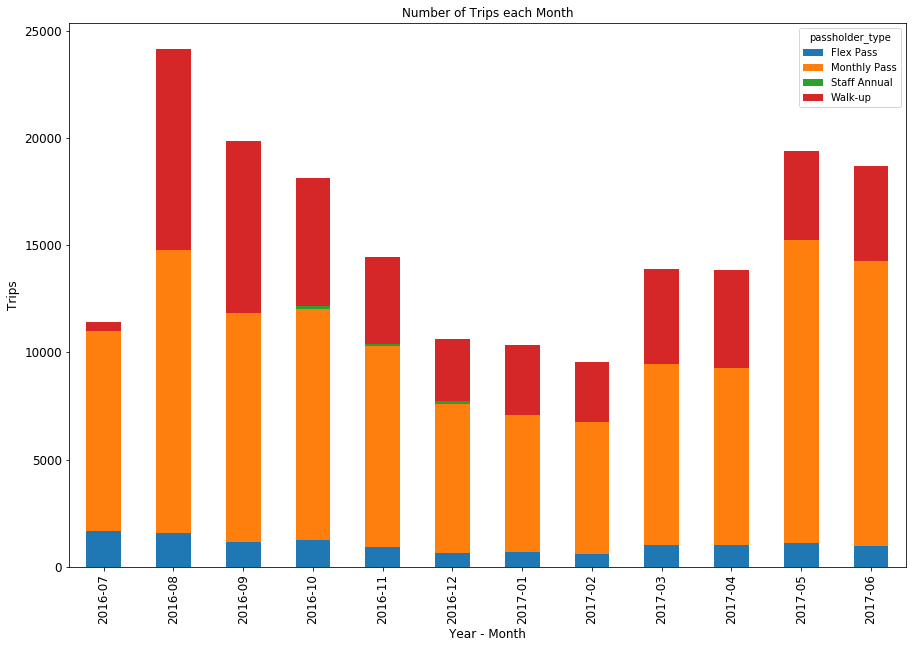

In [108]:
# Begin by converting the "start_time" and "end_time" columns into datetime64 columns, add a count column
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='raise', infer_datetime_format='True')
trips['end_time'] = pd.to_datetime(trips['end_time'], errors='raise', infer_datetime_format='True')
trips['count'] = 1

# Aggregate by month / year along the count column
per_month = trips.start_time.dt.to_period("M")
g = trips.groupby([per_month, 'passholder_type'])
ridership_by_month = g.sum()['count']

# Create a bar chart showing the percentage of time spent doing each activity
ridership_chart = ridership_by_month.unstack().plot(kind='bar', stacked=True, title='Number of Trips each Month', figsize=(15,10), fontsize=12)
ridership_chart.set_xlabel("Year - Month", fontsize=12)
ridership_chart.set_ylabel("Trips", fontsize=12)
plt.show()


##### Systemwide Ridership by Month
There are about 15k - 20k trips per month for the bikeshare system. As expected, ridership dips down in the so-called winter months and ticks back up inthe spring and summer. However, it is interesting to see the magnitude of ridership dropoff during the winter months, given that the weather in southern california doesn't vary all that much during those months.

The high mark for the program was the second month of operation, August 2016. Why not the first month? The system didn't launch until July 7, 2016, which meant that July was missing a quarter month of ridership. More reasons for the August peak: Metro had an [introductory 50 percent discount rate](http://thesource.metro.net/2016/07/07/its-official-metro-bike-share-program-launches-in-dtla/) that was offered August - September 2016, so walk-up trips that were normally 3.50 were discounted to 1.75; looking at the stacked bar chart above, you can see that both August and September had Walk-Up ridership numbers that have not been attained since. Also, a number of people (including myself) got a free month of ridership; you can see the bump in monthly pass ridership in August that was not present in July or September.

This bar chart seems to show that the monthly pass ridership is surpassing the ridership in the first few months, while the number of walk-ups has declined, and the number of Flex Pass trips has remained more or less the same throughout the entire year. It is interesting that there are so few trips made using the Flex Pass, which is what I currently have. It is a $40 / yr pass that gets you a 1.75 trip 30-minute trip fare, instead of the 3.50 full fare for Walk-ups. Also interesting is the brief period where there were a small number of trips made through a Staff Annual Pass. This program seems to have only existed from October through December of 2016, and doesn't look like it was that popular.

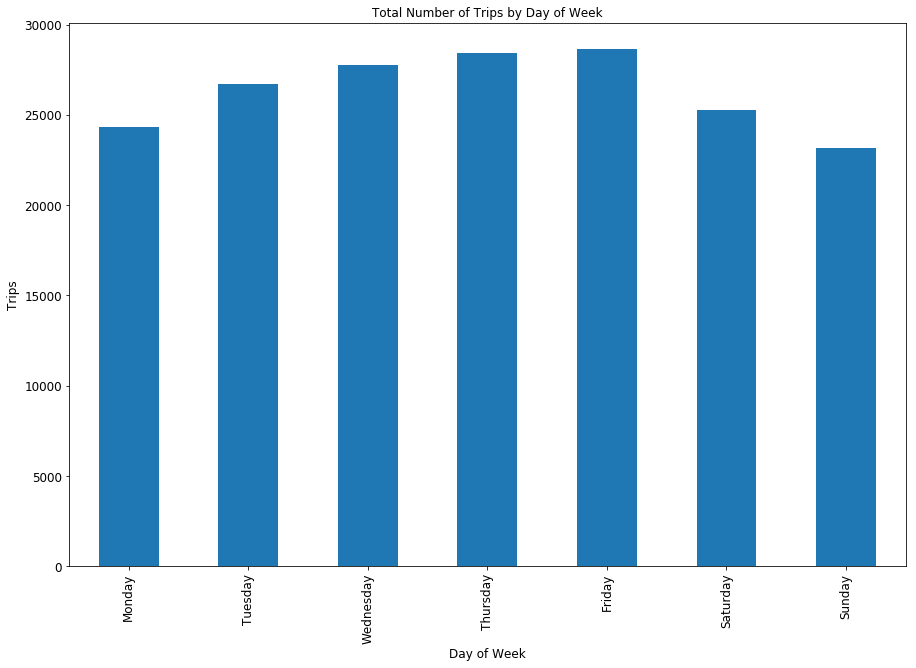

In [141]:
# Aggregate by day of the week
# dt.weekday assigns Monday=0, Sunday=6
per_dow = trips.start_time.dt.weekday
ridership_by_weekday = trips.groupby(per_dow).sum()['count'].to_frame('trips')
weekday_labels = [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']]
ridership_by_weekday = ridership_by_weekday.set_index(keys=weekday_labels)

# Bar chart with total weekday ridership
wkday_ridership_chart = ridership_by_weekday.plot(kind='bar',title='Total Number of Trips by Day of Week', legend=False, figsize=(15,10), fontsize=12)
wkday_ridership_chart.set_xlabel('Day of Week', fontsize=12)
wkday_ridership_chart.set_ylabel('Trips',fontsize=12)
plt.show()

##### Bikeshare Ridership by Day of the Week
Looking at the ridership per day of the week, it is interesting, though not surprising, to see Friday as the day with the highest ridership. I believe Friday is the peak day for all trips; it likely also helps that Friday is often more dress casual compared to the rest of the week, so people may be more inclined to ride when they are in more comfortable clothing.

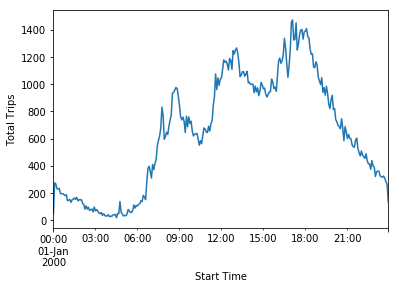

In [140]:
# Subset start_time from trips
trip_times = trips[['start_time','count']]

# Set the trip time as the index, replace the date values to a dummy date, and then delete the column
trip_times.index = trip_times['start_time']
trip_times.index = trip_times.index.map(lambda t: t.replace(year=2000, month=1, day=1))
del trip_times['start_time']

# Bucket the start times in 5 min increments & Plot the chart
trip_times_chart = trip_times.resample('5T').sum().plot(legend=False)
trip_times_chart.set_xlabel("Start Time")
trip_times_chart.set_ylabel("Total Trips")
plt.show()

##### Bikeshare Ridership by Time of Day
This is interesting. In addition to the morning and evening peak commute times, there is also a lunch peak period of ridership. This also makes sense given that the stations are located only downtown, so there are fewer people who are able to use Metro Bikeshare to commute compared to those who are downtown for work during the day and want to use the system to get around downtown. 

#### How Does Ridership Compare to Other Major Systems?
After 3 months of operation, the [LA Times reported](http://www.latimes.com/local/lanow/la-me-ln-los-angeles-bike-share-ridership-20160919-snap-story.html) that LA's system was not as well used compared to other bikeshare systems throughout the county. The LA Times picked 5 cities on this list (NY, Chicago, SF, DC, Santa Monica) and compared ridership to Metro's system using the metric of trips per bike within the first three months of operation. This is a snapshot of what they found:

![](images/la_times_graphic.PNG?raw=true)


Now that we have a full year of data, I wanted to (1) see if I could verify their analysis and (2) provide an update on this study and see if there were any changes looking at a year of ridership.

In addition to updating the ridership comparsion to those 5 cities, I also wanted to expand the comparison to other bikeshare systems that were not included in the LA times study. Greater Greater Washington [ranked](https://ggwash.org/view/62137/all-119-us-bikeshare-systems-ranked-by-size) all the bikeshare systems by size, measured by number of bikeshare stations. LA ranks 13th on this list, although I'm sure with the installation of stations in Pasadena (and soon enough in San Pedro as well) I'm sure this ranking will increase. Based on the Greater Greater Washington google spreadsheet, here is a table of the largest bikeshare systems in the U.S.

Rank | City | Stations
--- | --- | ---
1 | New York | 645
2 | Chicago | 581
3 | Washington | 437
4 | Minneapolis | 197
5 | Boston | 184
6 | Miami | 147
7 | Topeka | 138
8 | Philadelphia | 105
9 | Portland | 100
10 | San Diego | 95
11 | Denver | 88
12 | Santa Monica | 86
**13** | **Los Angeles** | **66**
14 | Phoenix | 63
15 | Buffalo | 63


From this table, you can see that there were several systems larger than Metro's but did not make the LA Times study, including Minneapolis, Boston, Miami, Topeka, Philadelphia, Portland, San Diego, and Denver. 

#### Bikeshare Ridership by Station
Let's look at the differences in ridership by station, separating origins and destinations.

In [ ]:
# Load the station file
station_path = 'data/metro_station_table.csv'
stations = pd.read_csv(station_path)

# First reformat stations df by setting station id as the index
stations = stations.set_index('Station ID')

# Count origins and destinations
stations_o_count = trips['count'].groupby(trips['start_station_id']).count().to_frame('o_ct')
stations_d_count = trips['count'].groupby(trips['end_station_id']).count().to_frame('d_ct')

# Combine O/D counts with station information
stations_od_count = pd.merge(stations_o_count, stations_d_count, right_index=True, left_index=True)
stations_count = pd.merge(stations, stations_od_count, left_index=True, right_index=True)
stations_count.head()

# Print out the max / min trip stats
print "The station with the highest number of origin trips is{}".format(stations_count.loc[stations_count['o_ct'].idxmax()][0])
print "The station with the highest number of destination trips is{}".format(stations_count.loc[stations_count['d_ct'].idxmax()][0])

Maybe make a make a map of the imbalances - 

In [ ]:
what is the density of bikeshare stations

In [ ]:
what is the density of bikeshare stations